# Wavelets Methods Apply to EEG dataset

Recently, most automated techniques for signal noise removal are based on the statistical distribution and spectrum
characteristics. Particularly, the analysis in the time-frequency domain produces superior signal processing results because it contains both the frequency and time components. so the goal of this notebook is to :

* Apply wavelet method to EEG dataset


* Perform feature extraction on this data

### Importation of the libraries

In [6]:
#======== To navigate through folders and files as a whole ============ 
from os import chdir

#======== To implement wavelet method ============ 
import pywt

#======== for data analysis ==================
import pandas as pd
import numpy as np
import scipy
from scipy import signal

#======== for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Load the data¶

Here we load the data

In [7]:

data = pd.read_csv('Data_Merge_2_b.csv')
# separate the predictor and response variables from the dataset
collist = data.columns.tolist()
cols_input = collist[0:4096]
data = data[cols_input + ["class"]]
data.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,class
0,11,1,-7,-24,-40,-50,-61,-68,-71,-78,...,-17,-14,-6,12,24,33,30,27,28,0
1,8,9,10,11,8,3,0,-1,-4,-6,...,-29,-30,-44,-56,-60,-57,-54,-43,-46,0
2,-91,-116,-70,5,45,56,12,-32,-66,-45,...,-15,-15,-3,-2,2,2,8,7,-22,0
3,-40,-58,-75,-88,-89,-81,-67,-52,-28,14,...,32,32,32,18,6,-3,-10,-13,-16,1
4,-985,-594,-120,308,620,644,538,320,116,-62,...,737,722,528,75,-487,-926,-1120,-1073,-734,1


### 2. Creation of Helper Functions

In [8]:
def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    """this function takes as input the signal, the treshold 
    and the wavelet family, remove the noise and return the
    new signal"""
    #definition of the treshold
    #thresh = thresh*np.nanmax(signal)
    thresh = 16*np.sqrt(2*np.log(signal.size))
    # Multilevel 1D Discrete Wavelet Transform of data.
    coeff = pywt.wavedec(signal, wavelet, mode="per")
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) 
                 for i in coeff[1:])
    #reconstruction of the signal
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

def Mean(x):
    """This function compute the
    mean of an Array x"""
    M = np.mean(x)
    return M

def Std(x):
    """This function compute the
    mean of an Array x"""
    STD = np.std(x)
    return STD

def Energy_factor(x):
    """This function compute the
    Energy factor of an Array x"""
    E=(np.mean(x**2))*len(x)
    return E

def Spectral_Entropy(x):
    """This function compute the
    spectral entropy of an Array x"""
    SE=spectral_entropy(x, sf=100, method='welch')
    return SE

def Median(x):
    """This function compute the
    median of an Array x"""
    return  np.percentile(x, 50)

def Max(x):
    """This function compute the
    maximum of an Array x"""
    return np.max(x)

def Min(x):
    """This function compute the
    minimum of an Array x"""
    return np.min(x)


def Total_variation(x):
    """This function compute the
    total variation of an Array x"""
    s=0
    for i in range(1,len(x)):
        s+=np.abs(x[i]-x[i-1])
    T_var=s/((len(x)+1)*(Max(x)-Min(x)))
    return T_var

def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False):
    """Spectral Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    sf : float
        Sampling frequency, in Hz.
    method : str
        Spectral estimation method:

        * ``'fft'`` : Fourier Transform (:py:func:`scipy.signal.periodogram`)
        * ``'welch'`` : Welch periodogram (:py:func:`scipy.signal.welch`)
    nperseg : int or None
        Length of each FFT segment for Welch method.
        If None (default), uses scipy default of 256 samples.
    normalize : bool
        If True, divide by log2(psd.size) to normalize the spectral entropy
        between 0 and 1. Otherwise, return the spectral entropy in bit.

    Returns
    -------
    se : float
        Spectral Entropy
    """
    from scipy.signal import periodogram, welch
    x = np.array(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se


def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp



### 3. Wavelet Threshold De-Noising

Generally, physiological signals are contaminated. Removing noise (denoising) is then an important step.

the wavelet threshold method can perform well in denoising nonstationary EEG signals

\begin{eqnarray}
\lambda=\sigma\sqrt{(2\log N)}
\end{eqnarray}

where λ is the wavelet threshold, σ is the standard deviation of the noise and N is the length of the
sample signals, respectively.

#### Below we plot in the same graph the original and the reconstructed signal after denoising for one patient

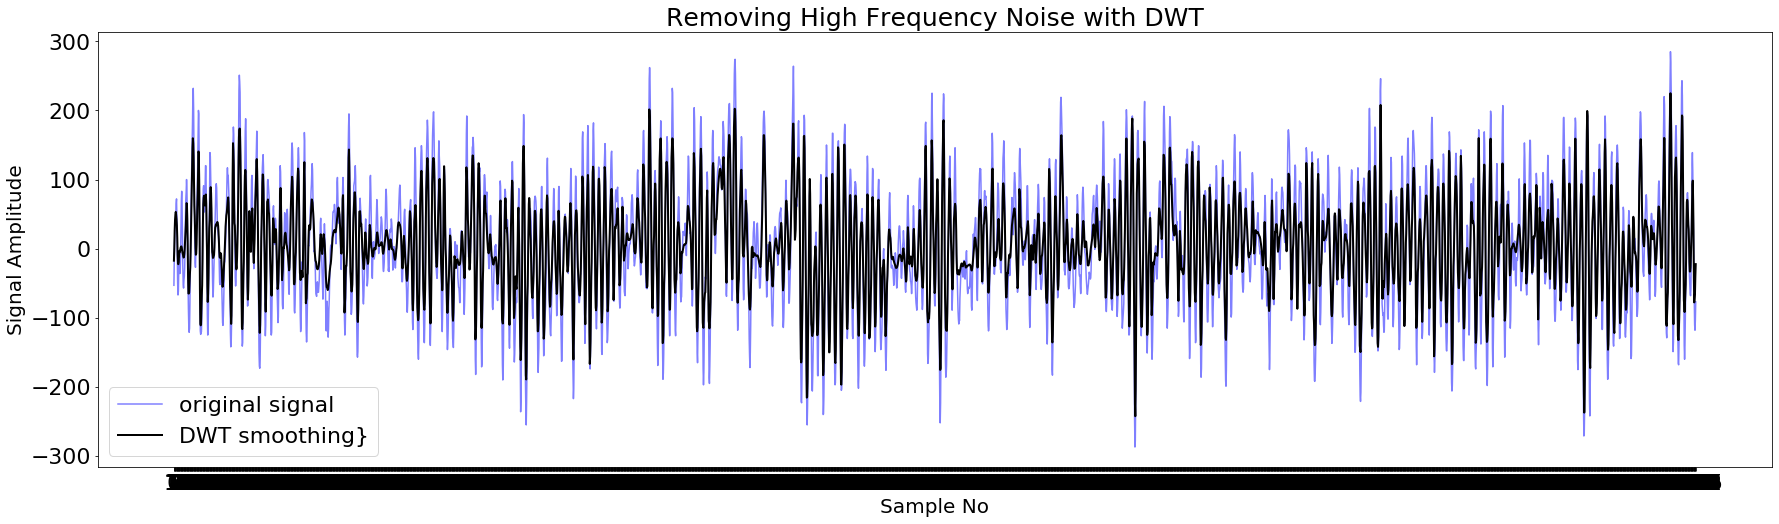

In [9]:
#original signal
signal =  data.loc[ 10 ,cols_input ]
plt.figure(figsize=(30,8))
plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.plot(signal, color="b", alpha=0.5, label='original signal')
#reconstructed signal after denoising
rec = lowpassfilter(signal,"db4")
plt.plot(rec,color="k",label='DWT smoothing}', linewidth=2)
plt.legend()
plt.title('Removing High Frequency Noise with DWT', fontsize=25)
plt.ylabel('Signal Amplitude', fontsize=20)
plt.xlabel('Sample No', fontsize=20)
plt.show()

### 4. Signal Decomposition

* The DWT is used to split a signal into different frequency sub-bands, as many as needed or as many as possible.


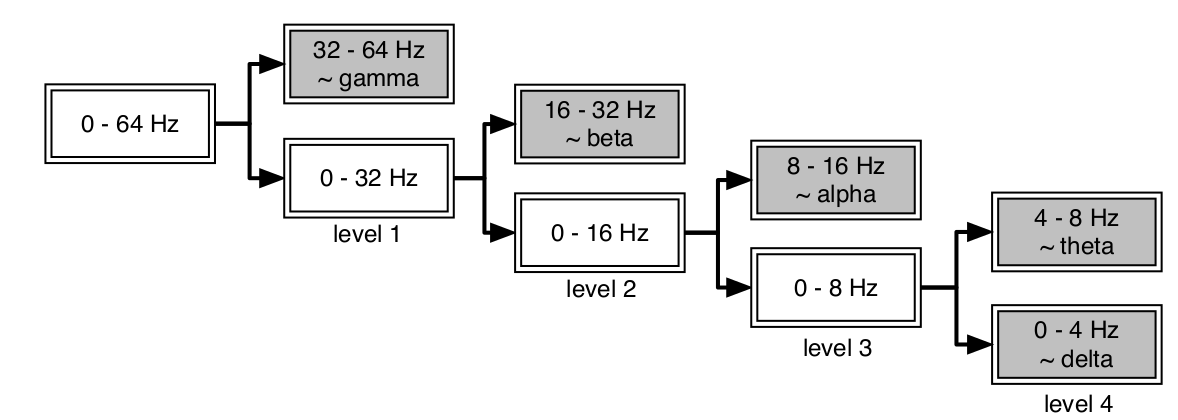

In [10]:
from IPython.display import Image
Image('/home/cyrillefeudjio/Documents/LDA and QDA/figures/decom.png',width=800)

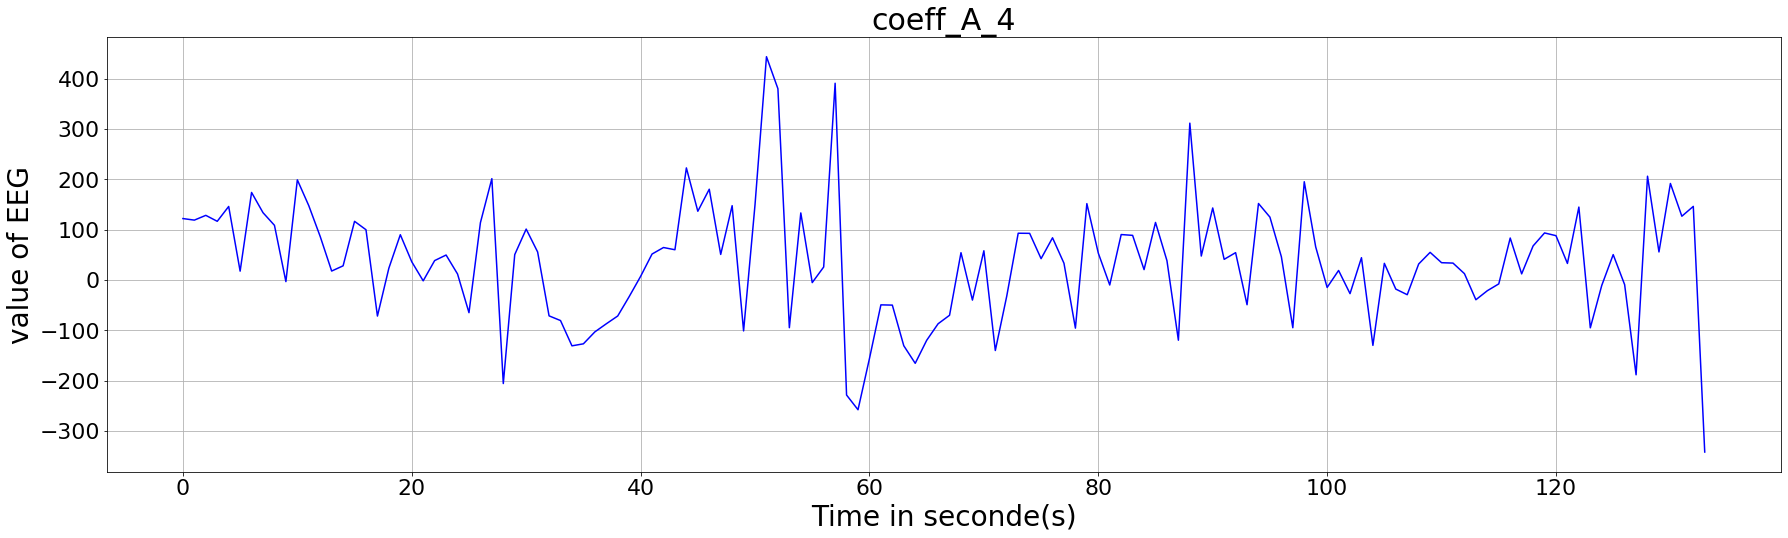

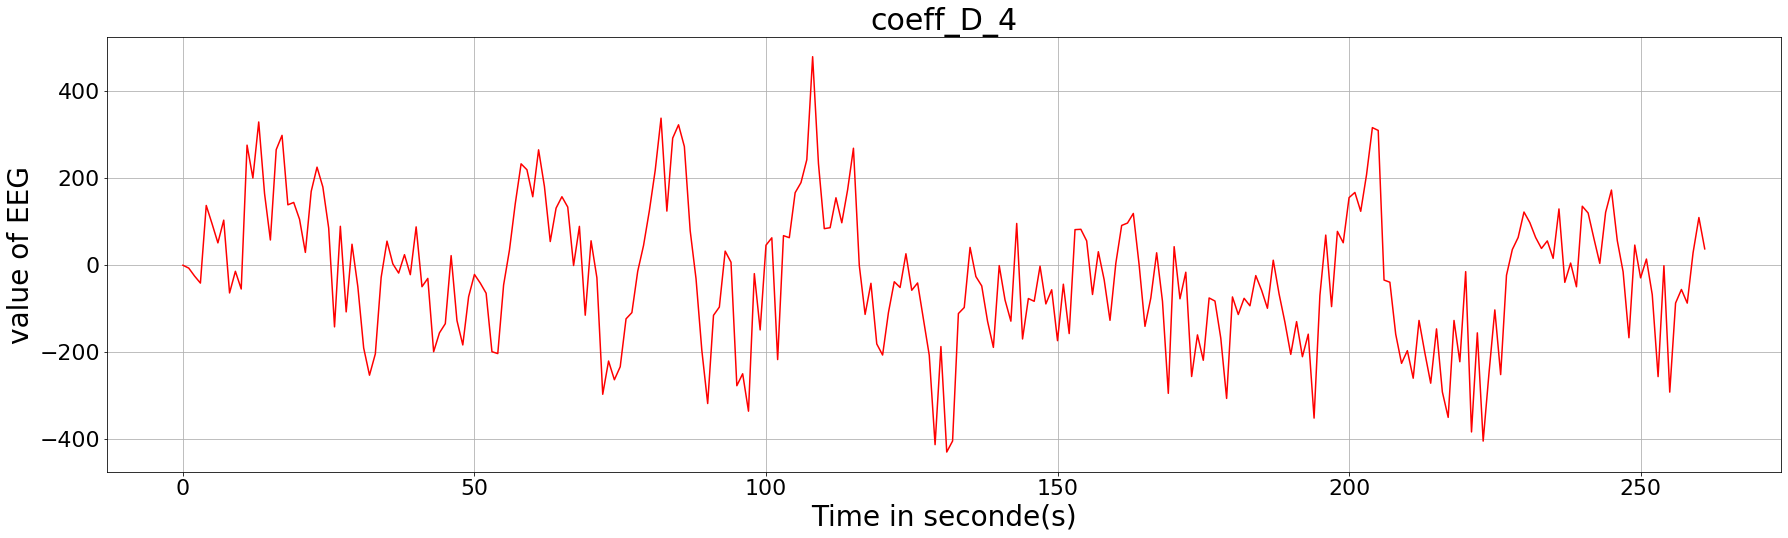

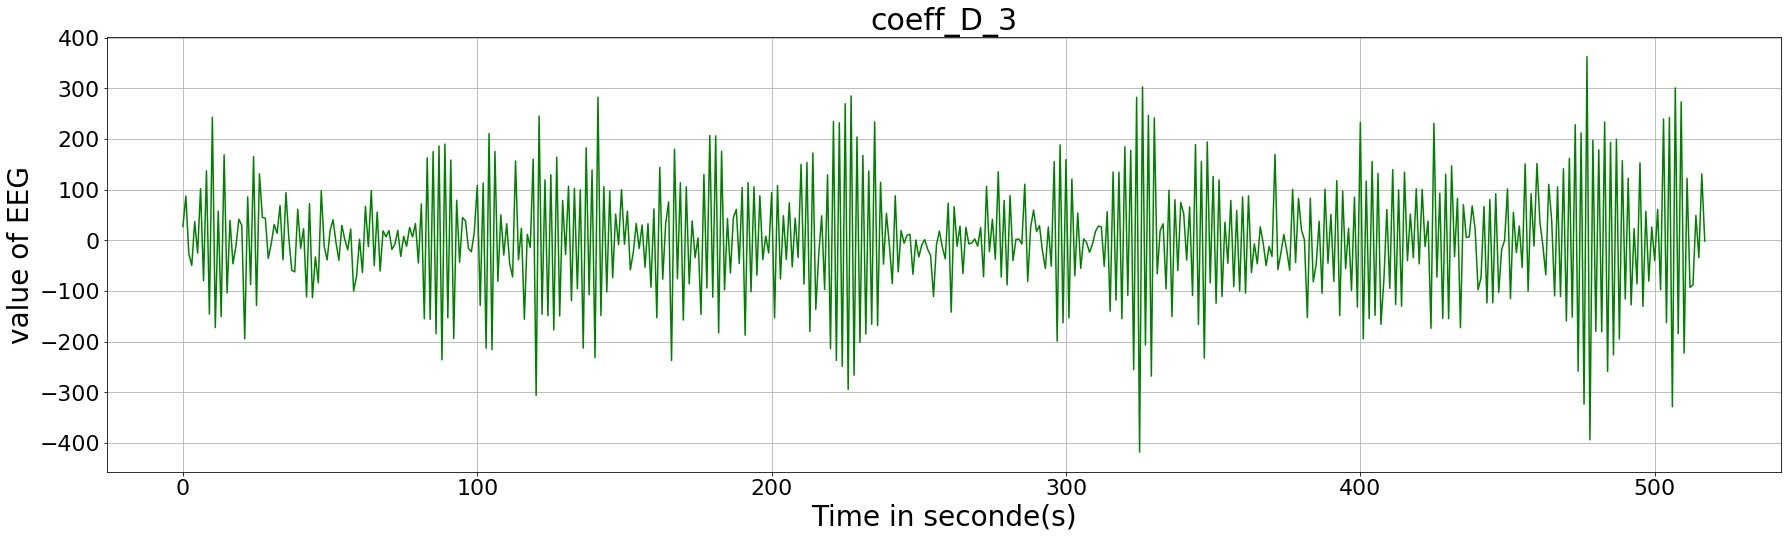

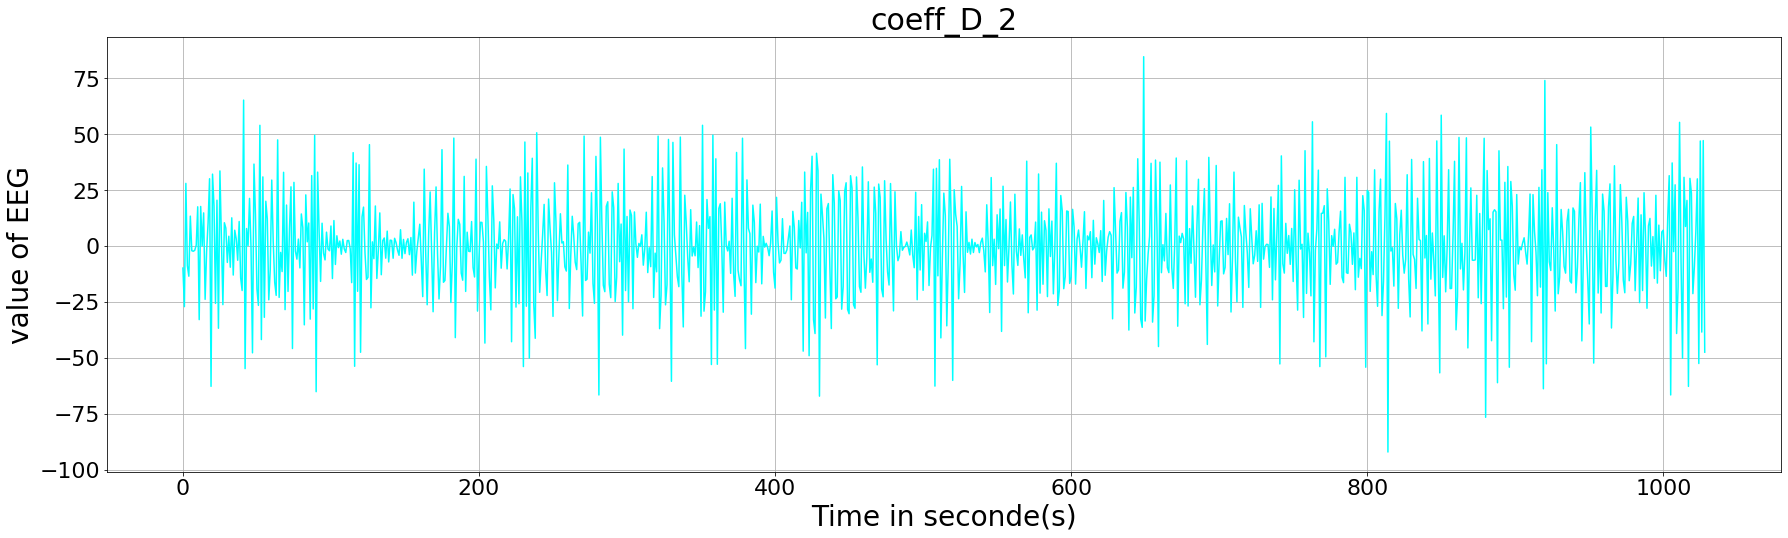

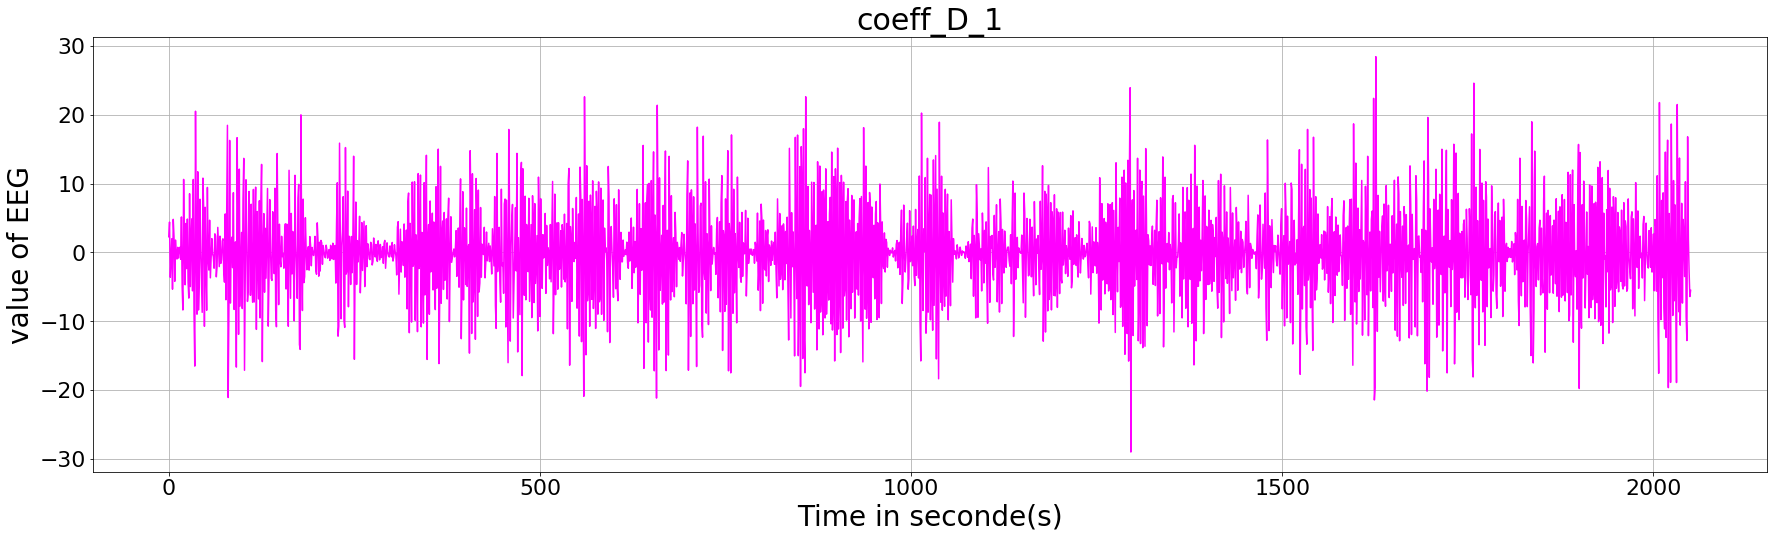

In [11]:
# empty list to save all the coefficients
list_values=list()
# signal after denoising
rec1=rec
for i in range(5):
    # Single level Discrete Wavelet Transform.
    (rec1, coeff_d) = pywt.dwt(rec1, 'db4')
    if i==4:
        list_values.append(rec1)
    else:
        list_values.append(coeff_d)
        
# list containing the names of save coeffs at each level.        
list_f=["coeff_D_1","coeff_D_2","coeff_D_3","coeff_D_4","coeff_A_4"]
cols =  ['blue' , 'red' , 'green' , 'cyan' , 'magenta']

#plot of differents coefficients that we are going to use
for i in range(5):
    plt.figure(i+1,figsize=(30,8))
    plt.rc('font', size=22)          # controls default text sizes
    plt.rc('axes', titlesize=30)     # fontsize of the axes title
    plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
    plt.plot(list_values[4-i],cols[i])
    plt.title (list_f[4-i] )
    plt.xlabel ('Time in seconde(s)')
    plt.ylabel('value of EEG')
    plt.grid(axis="both")


### 5. Creation of Helper Functions for Features Extraction 

* We generate features from each of the sub-band and use the collection of features as an input for a classifier.

#### 5.1 Feature extraction in Time-Frequency Domain

Very common time-frequency domain DWT based statistical features for classification include:
* mean average value
* standard deviation 
* Relative band power
* spectral entropy

In [12]:
def features_T_F(x,sf,band):
    """This function compute the desire 
    features in Time-Frequency Domain"""
    MAV = Mean(x)
    STD = Std(x)
    Rbp = bandpower(x, sf, band, relative=True)
    SE  = Spectral_Entropy(x)
    return MAV,STD,Rbp,SE


#### 5.2 Feature extraction in Frequency Domain

The relative power spectral density estimated by the coefficients of the FFT is extracted

In [13]:
def features_F(x):
    from scipy import signal
    def Power_spectral_density(x):
        """This function compute the
        Power_spectral_density of an Array x"""
        f, Pxx_den = signal.welch(x, 173.61, nperseg=134)
        return Mean(Pxx_den)
    return Power_spectral_density(x)

#### 5.3 Feature extraction in Time Domain

In the time domain, statistic features are extracted including:
* mean
* median
* standard deviation
* the total variation


Additionally, the **maximum**, **minimum** and the **total variation** measures of the DWT transform coefficients are also estimated in order to describe the nonstationary signals.

In [14]:
def features_T_1(x):
    """This function compute the mean, median,
    standard deviation and the total variation 
    In the time domain """
    Me= Median(x)
    mean = Mean(x)
    STD  = Std(x)
    Tv1  = Total_variation(x)
    return Me, mean,STD,Tv1

def features_T_2(x):
    """This function compute the maximum,
    minimum and the total variation measures 
    of the DWT transform coefficients"""
    Mi   = Min(x)
    Ma   = Max(x)
    Tv2  = Total_variation(x)
    return Mi, Ma, Tv2

### 6. Perform features extraction in the entire dataset


In [15]:
# Names of differents bandes
list_f=["D_1","D_2","D_3","D_4","A_4"]

# empty list to save the features
s=list()


for k in range(200):
    feats_names=list()
    # original signal
    signal =  data.loc[k , cols_input ]
    # denoising the signal
    rec = lowpassfilter(signal, 0.4,"db4")
    rec1=rec
    list_values=list()
    for i in range(5):
    # Decomposition of the signal.
        (rec1, coeff_d) = pywt.dwt(rec1, 'db4')
        if i==4:
            list_values.append(rec1)
        else:
            list_values.append(coeff_d)
            
    # Features extraction in time-frequency domain
    feats_1=np.zeros(20)
    band=[32,64]
    for k in range(5):
        a=features_T_F(list_values[k],173.61,band)
        feats_1[4*k]=a[0]
        feats_1[4*k+1]=a[1]
        feats_1[4*k+2]=a[2]
        feats_1[4*k+3]=a[3]
        feats_names+=["Mean_"+list_f[k], "Std_"+list_f[k] , "Rbp_"+list_f[k], "Sp_Entropy_"+list_f[k]]
        if k==4:
            band=[0,4]
        else:
            band=[band[0]/2,band[1]/2]
        
    # Features extraction in frequency domain
    feats_2=np.zeros(5)
    for k in range(5):
        feats_2[k]=features_F(list_values[k])
        feats_names+=["Psd_"+list_f[k]]
        
    # Features extraction in time domain
    feats_3=np.zeros(15)
    for k in range(5):
        a=features_T_2(list_values[k])
        feats_3[3*k]=a[0]
        feats_3[3*k+1]=a[1]
        feats_3[3*k+2]=a[2]
        feats_names+=["Min_"+list_f[k],"Max_"+list_f[k],"Total_var_"+list_f[k]]
    b1,b2,b3,b4=features_T_1(rec)
    a= b1,b2,b3,b4
    feats_names+=["Median_init_s", "Mean_init_s","Std_init_s","Total_var_init_s"]
    feats_4 = a  
    
    # list of all the features
    feats= list(feats_1)+ list(feats_2) + list(feats_3) + list(feats_4)
    s.append(feats)
        

/home/cyrillefeudjio/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 173 is greater than input length  = 134, using nperseg = 134
  .format(nperseg, input_length))
/home/cyrillefeudjio/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 134, using nperseg = 134
  .format(nperseg, input_length))


### 7. Create a new dataset containing all the extracted features

In [16]:
# Creation of dataframe
df = pd.DataFrame() 
for j in range(len(s)):
    df[j]=s[j]

In [17]:
df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000182,0.000041,0.000918,-0.004124,-0.183354,0.000046,-0.009677,-0.015709,-0.078313,0.000810,...,0.006952,0.000063,0.000251,0.001180,-0.557726,-0.000633,0.000333,0.000108,-0.003682,0.003826
1,0.628732,0.227392,2.343871,5.678712,56.812789,0.793378,10.664481,17.369793,32.224311,23.770666,...,17.159381,3.734124,2.779835,4.374360,56.944977,1.825102,0.542310,1.983844,3.698052,22.434998
2,0.234667,0.215876,0.327462,0.290613,0.359829,0.260465,0.271002,0.264350,0.316378,0.318302,...,0.327879,0.269136,0.260600,0.237547,0.289259,0.305012,0.231512,0.338919,0.311414,0.278162
3,5.315154,5.360491,5.937007,6.002029,6.181303,5.929511,6.225550,6.229904,6.405527,6.430699,...,6.348404,6.270023,5.529410,5.231398,6.336656,6.145226,5.549445,5.853221,6.297981,6.386849
4,0.000650,-0.002918,0.013448,0.009168,-0.736073,-0.001202,-0.031148,0.082549,-0.023262,0.040768,...,0.017462,0.002917,-0.009565,-0.022226,0.369940,0.018278,-0.006675,-0.001031,-0.020521,0.053343
5,1.856816,0.695792,8.490275,19.575408,300.230599,2.563721,33.039330,60.453374,143.461995,104.949722,...,71.127179,12.214573,9.086293,13.871591,250.101553,6.491059,1.652872,7.343874,13.505049,78.735234
6,0.012422,0.010667,0.001484,0.006301,0.000931,0.006480,0.004378,0.006279,0.003648,0.003724,...,0.002639,0.005525,0.001064,0.001645,0.004388,0.004951,0.011255,0.001164,0.002344,0.006416
7,5.707399,5.796413,5.756531,5.914038,5.755405,6.243041,5.998385,5.917607,6.062517,6.106636,...,5.977258,6.165251,6.112933,5.907206,6.044660,6.080876,5.948978,5.968540,5.907440,6.118061
8,-0.066231,0.020551,0.482243,-0.654179,33.583420,-0.046684,-1.478760,0.884072,-6.227169,15.114651,...,8.688823,1.437880,-0.380436,2.045058,-12.120288,0.020814,0.033489,-0.925086,-0.095931,2.626818
9,13.969496,5.139726,28.884508,86.889333,895.814751,15.172037,87.052956,290.037630,622.284277,471.900928,...,259.455285,58.199296,45.890070,84.107272,792.552867,28.611402,11.997929,24.563385,44.286236,358.592907


In [18]:
# Transpose to make Each raw correspond to one patient 
df1=df.T
# Define the names of all the columns
df1.columns= feats_names
#define a column for different class
df1["class"]= data["class"]

In [19]:
# separate the predictor and response variables from the dataset
collist = df1.columns.tolist()
cols_input_2 = collist[0:len(df1.loc[0,:])-2]
df1 = df1[cols_input_2 + ["class"]]


The data are now tidy.

   * Each raw correspond to one patient
   * Each column correspond to on feature.



#### 7.1 visualization of the new dataframe

In [20]:
# visualization of the final dataframe
df1.head()

,Mean_D_1,Std_D_1,Rbp_D_1,Sp_Entropy_D_1,Mean_D_2,Std_D_2,Rbp_D_2,Sp_Entropy_D_2,Mean_D_3,Std_D_3,...,Min_D_4,Max_D_4,Total_var_D_4,Min_A_4,Max_A_4,Total_var_A_4,Median_init_s,Mean_init_s,Std_init_s,class
0,0.000182,0.628732,0.234667,5.315154,0.000650,1.856816,0.012422,5.707399,-0.066231,13.969496,...,-119.308604,139.291148,0.150690,-410.303839,280.924933,0.138484,-18.304969,-17.761230,23.097536,0
1,0.000041,0.227392,0.215876,5.360491,-0.002918,0.695792,0.010667,5.796413,0.020551,5.139726,...,-45.849066,42.986904,0.142349,-369.619263,-52.870536,0.108318,-38.356266,-38.085693,10.345948,0
2,0.000918,2.343871,0.327462,5.937007,0.013448,8.490275,0.001484,5.756531,0.482243,28.884508,...,-171.712791,197.362606,0.114134,-261.280564,247.284234,0.124872,-14.881921,-14.171631,23.396688,0
3,-0.004124,5.678712,0.290613,6.002029,0.009168,19.575408,0.006301,5.914038,-0.654179,86.889333,...,-750.981245,724.510861,0.215682,-727.436479,255.026796,0.232628,-46.142385,-44.575195,85.785841,1
4,-0.183354,56.812789,0.359829,6.181303,-0.736073,300.230599,0.000931,5.755405,33.583420,895.814751,...,-2331.447021,2355.103934,0.177357,-6632.058763,2374.423245,0.125831,91.164291,-14.004639,463.704858,1


#### 7.2 Save the new dataframe

In [21]:
#=============================== path to save the data in my computer ======================
txt_file_path = "/home/cyrillefeudjio/Documents/LDA and QDA/ALL"

#change to the folder of interest
chdir(txt_file_path)

#save the final data
df1.to_csv("Data_db4_b.csv", index=False, encoding="utf-8")